In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import csv
import random
import pandas as pd
import scipy.stats as st

In [2]:
#give the file names that we will be analyzing. Need a calibration file and a run file should match
name='with_watchdogandpi_controlfilms_240625'
run_file=pd.read_csv('./'+name+'.csv',header=0)
calibration=pd.read_csv('./'+name+'calibration.csv',header=0)

In [3]:
#define the calibration masses (listed as the headers in the calibration csv) and get slopes for each scale
cal_masses=np.array([85,90,92,93,95,100])
scales_slopes=[]
scales_intercept=[]
errors_calibration=[] #list of lists [[error in slope, error in intercept]]
for i in range(0,16):
    scale_values=np.array(calibration.iloc[i,1:].values.tolist())
    #print(i)
    output=st.linregress(cal_masses,scale_values)
    scales_slopes+=[output.slope]
    scales_intercept+=[output.intercept]
    errors_calibration+=[[output.stderr,output.intercept_stderr]]

#plot the calibration curves

print(scales_slopes)

[3228.7386454183275, 3179.9872509960173, 3243.605577689243, 3067.547410358565, 3132.5637450199215, 3122.8697211155395, 2938.6541832669336, 3060.2366533864556, 3196.2239043824716, 3165.329880478088, 3252.73187250996, 2860.6223107569717, 3075.939043824702, 3004.973705179283, 3120.8450199203157, 2106.1406374501985]


In [4]:
def convert_to_mass(file_name,slopes,intercepts):
    cell_=pd.read_csv('./'+file_name+'.csv',header=0)

    mass_data=cell_
    #print(mass_data)
    for i in range(1,17,1):
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2])
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1])
        mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]=mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]/slopes[i-1]
        #print(mass_data)

    normalization=mass_data.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    update1=mass_data.apply(lambda x: x-normalization, axis=1)
    permeance=[0]*16
    error=[0]*16
    for i in range(1,13,1):
        mass = update1.iloc[500:15500, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy()
        time = update1.iloc[500:15500, 2 * (i - 1):2 * (i - 1) + 1].to_numpy()
        mass=np.reshape(mass,-1)
        time=np.reshape(time,-1)
        output=st.linregress(time, mass)
        # to get permeance in g/(hr*m^2)
        # slope is g/min. Multiply by 60min to get per hour
        # divide by 10cm^2 area. Multiply by 100^2 for cm^2/m^2
        permeance[i-1]=output.slope*60/(10)*(100**2)
        error[i - 1] = output.stderr * 60 / (10) * (100 ** 2)
    for i in range(13,17,1):
        mass = update1.iloc[500:15500, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy()
        time = update1.iloc[500:15500, 2 * (i - 1):2 * (i - 1) + 1].to_numpy()
        mass=np.reshape(mass,-1)
        time=np.reshape(time,-1)
        output=st.linregress(time, mass)
        # to get permeance in g/(hr*m^2)
        # slope is g/min. Multiply by 60min to get per hour
        # divide by 10cm^2 area. Multiply by 100^2 for cm^2/m^2
        permeance[i-1]=output.slope*60/(10)*(100**2)
        error[i - 1] = output.stderr * 60 / (10) * (100 ** 2)


    return (update1,permeance,error)

In [5]:
output=convert_to_mass(name, scales_slopes,scales_intercept)
print(output[1])
print(output[2])

[0.019593072817780537, 0.059055339685262435, -0.20050123588757596, -0.030860247932848812, -0.006816112748129572, 0.05006204993533422, -0.08824992550416436, -0.3204440766835065, -0.013425135362912814, -0.2953251569982801, -0.11760290321547073, 0.040944206057255156, -0.02802032173581694, 0.06475033972247461, 0.004889399842832606, -0.14788034855929819]
[0.002960879542234491, 0.00219862522008089, 0.0018034600665528052, 0.00833268332055089, 0.0013862500515982293, 0.004588839897912117, 0.001208727966598919, 0.001732479149271505, 0.0013377128816535648, 0.002808263805066154, 0.0023166351317520217, 0.005225153621814182, 0.0016341945760885946, 0.003990807009251999, 0.0029552211158689256, 0.0032387820947008413]


In [6]:
def plot_curves(numpyarray,save_name,permeance,error):
    figure1, ax=plt.subplots(4,4,sharex='col',sharey='row')
    for j in range(3):
        for k in range(4):
            i=(j*4)+k
            print(i)
            ax[j,k].scatter(numpyarray.iloc[:,2*i],numpyarray.iloc[:,2*i+1])
            #ax[j,k].set_xlabel("Elapsed Time (minutes)")
            #ax[j,k].set_ylabel("Mass (grams)")
            ax[j,k].set_ylim(-3,0.5)
            ax[j,k].set_xlim(0,30000)
            ax[j,k].text(3000,-2,str(permeance[i])[0:6])
            #ax[j,k].text(1000,-0.75,'+/- '+str(error[i])[0:5])
    j=3
    for k in range(4):
            i=(j*4)+k
            print(i)
            ax[j,k].scatter(numpyarray.iloc[:,2*i],numpyarray.iloc[:,2*i+1])
            #ax[j,k].set_xlabel("Elapsed Time (minutes)")
            #ax[j,k].set_ylabel("Mass (grams)")
            ax[j,k].set_ylim(-5,0.5)
            ax[j,k].set_xlim(0,30000)
            ax[j,k].text(3000,-1,str(permeance[i])[0:6])
            #ax[j,k].text(1000,-0.75,'+/- '+str(error[i])[0:5])
    figure1.supxlabel("Elapsed Time (minutes)")
    figure1.supylabel("Mass (grams)")
    figure1.savefig('./Film_plots/' + save_name+'15000pts.png', dpi=300)
    plt.set_cmap('Greens')
    figure1.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/var/folders/t5/wsvlnfc52kd7dmby8bpwq66r0000gn/T/ipykernel_35855/3538930492.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure1.show()


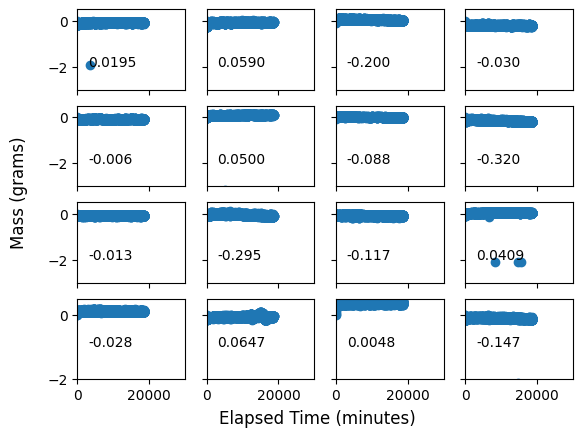

In [7]:
plot_curves(output[0],name,output[1],output[2])

In [8]:
def convert_to_averages(file_name,slopes,intercepts):
    cell_=pd.read_csv('./'+file_name+'.csv',header=0)

    mass_data=cell_
    #print(mass_data)
    for i in range(1,17,1):
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2])
        #print(mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]*slopes[i-1])
        mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]=mass_data.iloc[:,2*(i-1)+1:2*(i-1)+2]/slopes[i-1]
        #print(mass_data)

    normalization=mass_data.iloc[0,:].to_numpy()
    #print(normalization)
    #get an updated matrix
    update1=mass_data.apply(lambda x: x-normalization, axis=1)
    permeance=[0]*16
    error=[0]*16
    for i in range(1,17,1):
        mass_1= np.average(update1.iloc[500:600, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy())
        mass_2=np.average(update1.iloc[5000:5100, 2 * (i - 1) + 1:2 * (i - 1) + 2].to_numpy())
        time_1= np.average(update1.iloc[500:600, 2 * (i - 1):2 * (i - 1) + 1].to_numpy())
        time_2= np.average(update1.iloc[5000:5100, 2 * (i - 1):2 * (i - 1) + 1].to_numpy())
        print('scale ',i)
        print('time 1: ',time_1,' mass 1: ',mass_1)
        print('time 2: ',time_2,' mass 2: ',mass_2)





In [9]:
output=convert_to_averages(name, scales_slopes,scales_intercept)

scale  1
time 1:  1099.0  mass 1:  -0.10099145078302599
time 2:  10099.0  mass 2:  -0.08442987492556867
scale  2
time 1:  1099.0  mass 1:  -0.0753902393554894
time 2:  10099.0  mass 2:  -0.0687128540944792
scale  3
time 1:  1099.0  mass 1:  0.07919581892661938
time 2:  10099.0  mass 2:  0.05710312045153046
scale  4
time 1:  1099.0  mass 1:  -0.21911902575010062
time 2:  10099.0  mass 2:  -0.21420793621025466
scale  5
time 1:  1099.0  mass 1:  -0.08866571364798062
time 2:  10099.0  mass 2:  -0.07942791280641359
scale  6
time 1:  1099.0  mass 1:  0.08822718352194911
time 2:  10099.0  mass 2:  0.10050403251784815
scale  7
time 1:  1099.0  mass 1:  0.024169567281658005
time 2:  10099.0  mass 2:  0.016222051669584802
scale  8
time 1:  1099.0  mass 1:  -0.11312000972765304
time 2:  10099.0  mass 2:  -0.14721737271575008
scale  9
time 1:  1099.0  mass 1:  -0.08719758325373178
time 2:  10099.0  mass 2:  -0.08395344257078989
scale  10
time 1:  1099.0  mass 1:  -0.046481411276392354
time 2:  100